In [ ]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf

# Define image directories
low_light_dir = "/content/drive/MyDrive/train-20241116T084056Z-001/train/low"  # Directory containing low-light images
enhanced_dir = "/content/drive/MyDrive/train-20241116T084056Z-001/train/high"  # Directory containing enhanced images

# Define image loading and preprocessing function
def load_image(image_path, size=(256, 256)):
    img = Image.open(image_path)
    img = img.resize(size)  # Resize the images to 256x256
    img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0,1]
    return img

# Load all images into arrays
low_light_images = []
enhanced_images = []

for img_name in os.listdir(low_light_dir):
    low_img_path = os.path.join(low_light_dir, img_name)
    enhanced_img_path = os.path.join(enhanced_dir, img_name)  # Assuming matching file names

    # Append loaded and processed images
    low_light_images.append(load_image(low_img_path))
    enhanced_images.append(load_image(enhanced_img_path))

# Convert lists to numpy arrays
low_light_array = np.array(low_light_images)
enhanced_array = np.array(enhanced_images)

# Convert the arrays to float32
low_light_array = low_light_array.astype(np.float32)
enhanced_array = enhanced_array.astype(np.float32)

print("Dataset Loaded. Shape of low-light images:", low_light_array.shape)

Dataset Loaded. Shape of low-light images: (236, 256, 256, 3)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)

    # Decoder
    upconv2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(bottleneck)
    concat2 = tf.keras.layers.concatenate([conv2, upconv2], axis=-1)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)

    upconv1 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(conv3)
    concat1 = tf.keras.layers.concatenate([conv1, upconv1], axis=-1)
    conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)

    # Output layer
    outputs = tf.keras.layers.Conv2D(3, 1, activation='sigmoid')(conv4)

    return tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Initialize the UNet model
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        131,200 │ conv2d_2[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 64)   │         32,832 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 128)  │              0 │ conv2d[0][0],          │
│ (Concatenate)             │                        │                │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │         73,792 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 3)    │            195 │ conv2d_4[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 903,875 (3.45 MB)

 Trainable params: 903,875 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def color_alignment_loss(y_true, y_pred):
    # Compute histograms of the true and predicted images
    true_hist = tf.histogram_fixed_width(y_true, [0.0, 1.0], nbins=64)
    pred_hist = tf.histogram_fixed_width(y_pred, [0.0, 1.0], nbins=64)

    # Normalize histograms
    true_hist = true_hist / tf.reduce_sum(true_hist)
    pred_hist = pred_hist / tf.reduce_sum(pred_hist)

    # Calculate Wasserstein distance between histograms
    cumulative_true_hist = tf.cumsum(true_hist)
    cumulative_pred_hist = tf.cumsum(pred_hist)
    w_distance = tf.reduce_sum(tf.abs(cumulative_true_hist - cumulative_pred_hist))

    return w_distance

def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE for image structure
    cal_loss = color_alignment_loss(y_true, y_pred)        # Color alignment loss (CAL)
    return mse_loss + tf.cast(0.01, tf.float32) * tf.cast(cal_loss, tf.float32)                      # Weighting factor for CAL

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=['mse'])

# Train the model
history = model.fit(low_light_array, enhanced_array, epochs=20, batch_size=4)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 475s 8s/step - loss: 0.1484 - mse: 0.0479
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 504s 8s/step - loss: 0.0642 - mse: 0.0189
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 495s 8s/step - loss: 0.0541 - mse: 0.0166
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 505s 8s/step - loss: 0.0547 - mse: 0.0161
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 498s 8s/step - loss: 0.0516 - mse: 0.0146
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 504s 8s/step - loss: 0.0554 - mse: 0.0154
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - loss: 0.0451 - mse: 0.0125
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 504s 8s/step - loss: 0.0433 - mse: 0.0123
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 502s 8s/step - loss: 0.0390 - mse: 0.0110
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 502s 8s/step - loss: 0.0464 - mse: 0.0130
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 467s 8s/step - loss: 0.0414 - mse: 0.0112
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 503s 8s/step - loss: 0.0348 - mse: 0.0102
Epoch 13/20
59/59 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


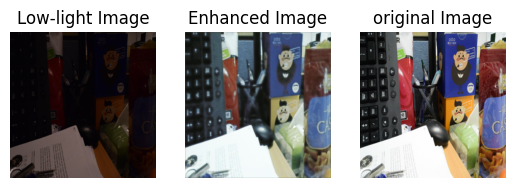

In [ ]:
import matplotlib.pyplot as plt

# Load a test image
test_image_path = '/content/drive/MyDrive/eval-20241116T084057Z-001/eval/low/100.png'
test_image = load_image(test_image_path)
org_img=load_image('/content/drive/MyDrive/eval-20241116T084057Z-001/eval/high/100.png')
# Predict the enhanced image
test_image_expanded = np.expand_dims(test_image, axis=0)
enhanced_image = model.predict(test_image_expanded)

# Visualize the input and output
plt.subplot(1, 3, 1)
plt.title('Low-light Image')
plt.axis('off')
plt.imshow(test_image)

plt.subplot(1, 3, 2)
plt.title('Enhanced Image')
plt.axis('off')
plt.imshow(np.squeeze(enhanced_image))

plt.subplot(1, 3, 3)
plt.title('original Image')
plt.imshow(org_img)
plt.axis('off')
plt.show()

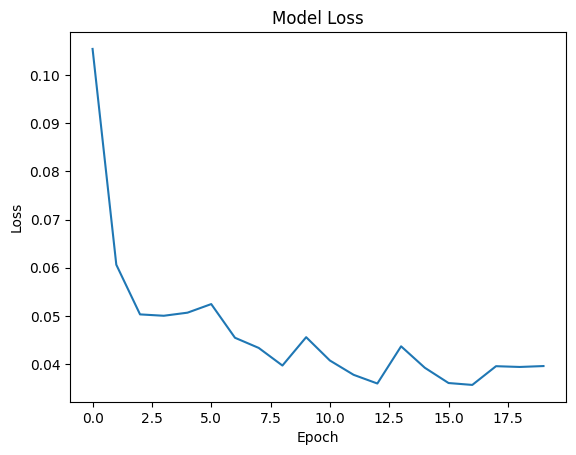

In [ ]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
!pip install h5py --upgrade


In [ ]:
# Save the entire model including optimizer state
model.save('/content/drive/MyDrive/my_model.keras', include_optimizer=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from tensorflow.keras.models import load_model

# Load the model with custom loss
loaded_model = load_model(
    '/content/drive/MyDrive/my_model.keras',
    custom_objects={'combined_loss': combined_loss}
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


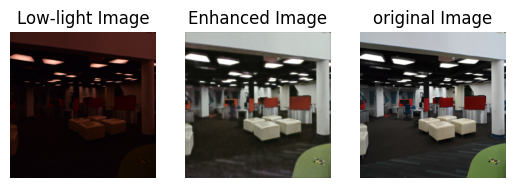

In [ ]:
import matplotlib.pyplot as plt

# Load a test image
test_image_path = '/content/drive/MyDrive/eval-20241116T084057Z-001/eval/low/289.png'
test_image = load_image(test_image_path)
org_img=load_image('/content/drive/MyDrive/eval-20241116T084057Z-001/eval/high/289.png')
# Predict the enhanced image
test_image_expanded = np.expand_dims(test_image, axis=0)
enhanced_image = model.predict(test_image_expanded)

# Visualize the input and output
plt.subplot(1, 3, 1)
plt.title('Low-light Image')
plt.axis('off')
plt.imshow(test_image)

plt.subplot(1, 3, 2)
plt.title('Enhanced Image')
plt.axis('off')
plt.imshow(np.squeeze(enhanced_image))

plt.subplot(1, 3, 3)
plt.title('original Image')
plt.imshow(org_img)
plt.axis('off')
plt.show()